__Chapter 6 - Learning Best Practices for Model Evaluation and Hyperparameter Tuning__

1. [Import](#Import)
1. [Streamlining workflows with pipelines](#Streamlining-workflows-with-pipelines)
1. [Combining transformers and estimators in a pipeline](#Combining-transformers-and-estimators-in-a-pipeline)
1. [Assessing model performance with cross-validation](#Assessing-model-performance-with-cross-validation)
1. [Debugging algorithms with learning an validation curves](#Debugging-algorithms-with-learning-an-validation-curves)
1. [Addressing overfitting and underfitting with validation curves](#Addressing-overfitting-and-underfitting-with-validation-curves)
1. [Fine-tuning machine learning models via grid search](#Fine-tuning-machine-learning-models-via-grid-search)
    1. [Algorithm selection with nested cross-validation](#Algorithm-selection-with-nested-cross-validation)
1. [Performance evaluation metrics](#Performance-evaluation-metrics)
    1. [Confusion matrix](#Confusion-matrix)
    1. [Optimizing the precision and recall of a classification model](#Optimizing-the-precision-and-recall-of-a-classification-model)
    1. [Receiver operating characteristic](#Receiver-operating-characteristic)
    1. [Scoring metrics for multiclass classification](#Scoring-metrics-for-multiclass-classification)
1. [Dealing with class imbalance](#Dealing-with-class-imbalance)
    1. [Sampling techniques for imbalanced datasets](#Sampling-techniques-for-imbalanced-datasets)

# Import

<a id = 'Import'></a>

In [1]:
# standard libary and settings
import os
import sys
import importlib
import itertools
from io import StringIO
import warnings

warnings.simplefilter("ignore")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np

np.set_printoptions(threshold=np.inf, suppress=True)
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.options.display.float_format = "{:,.6f}".format

# modeling extensions
import sklearn.base as base
import sklearn.cluster as cluster
import sklearn.datasets as datasets
import sklearn.decomposition as decomposition
import sklearn.ensemble as ensemble
import sklearn.feature_extraction as feature_extraction
import sklearn.feature_selection as feature_selection
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import sklearn.neighbors as neighbors
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
import sklearn.svm as svm
import sklearn.tree as tree
import sklearn.discriminant_analysis as discriminant_analysis
import sklearn.utils as utils

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt

# custom extensions and settings
sys.path.append("/home/mlmachine") if "/home/mlmachine" not in sys.path else None
sys.path.append("/home/prettierplot") if "/home/prettierplot" not in sys.path else None

import mlmachine as mlm
from prettierplot.plotter import PrettierPlot
import prettierplot.style as style

# magic functions
%matplotlib inline

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Streamlining workflows with pipelines

The Pipeline class is handy when we need to fit a model and apply an arbitrary number of transformation steps, including features scaling, feature selection, and/or feature extraction.

<a id = 'Streamlining-workflows-with-pipelines'></a>

In [2]:
# load and inspect data
cancer_data = datasets.load_breast_cancer()

df_cancer = pd.DataFrame(
    data=np.c_[cancer_data.target, cancer_data.data],
    columns=["Label"] + list(cancer_data.feature_names),
)
df_cancer["Label"] = np.where(df_cancer["Label"] == 1, 0, 1)
df_cancer[:5]

,Label,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1,17.990000,10.380000,122.800000,"1,001.000000",0.118400,0.277600,0.300100,0.147100,0.241900,...,25.380000,17.330000,184.600000,"2,019.000000",0.162200,0.665600,0.711900,0.265400,0.460100,0.118900
1,1,20.570000,17.770000,132.900000,"1,326.000000",0.084740,0.078640,0.086900,0.070170,0.181200,...,24.990000,23.410000,158.800000,"1,956.000000",0.123800,0.186600,0.241600,0.186000,0.275000,0.089020
2,1,19.690000,21.250000,130.000000,"1,203.000000",0.109600,0.159900,0.197400,0.127900,0.206900,...,23.570000,25.530000,152.500000,"1,709.000000",0.144400,0.424500,0.450400,0.243000,0.361300,0.087580
3,1,11.420000,20.380000,77.580000,386.100000,0.142500,0.283900,0.241400,0.105200,0.259700,...,14.910000,26.500000,98.870000,567.700000,0.209800,0.866300,0.686900,0.257500,0.663800,0.173000
4,1,20.290000,14.340000,135.100000,"1,297.000000",0.100300,0.132800,0.198000,0.104300,0.180900,...,22.540000,16.670000,152.200000,"1,575.000000",0.137400,0.205000,0.400000,0.162500,0.236400,0.076780


In [3]:
# encode class labels
X = df_cancer.iloc[:, 1:].values
y = df_cancer.iloc[:, 0].values
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
print("Unique class labels: {0}".format(np.unique(y)))

Unique class labels: [0 1]


In [4]:
# train/test split
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=1
)

# Combining transformers and estimators in a pipeline

Combine data standardizations, Principal Component Analysis and Logistic Regression into one pipeline.

<a id = 'Combining-transformers-and-estimators-in-a-pipeline'></a>

In [5]:
# scaling, dimensionality reduction, logistic regression pipeline
pipe = pipeline.make_pipeline(
    preprocessing.StandardScaler(),
    decomposition.PCA(n_components=2),
    linear_model.LogisticRegression(random_state=1),
)
pipe.fit(X_train, y_train)
y_pred_test = pipe.predict(X_test)
print("Test set accuracy: {:.3f}".format(pipe.score(X_test, y_test)))

Test set accuracy: 0.956


> Remarks - make_pipeline takes in an arbitrary number of transformers, which are objects that include fit and transform methods. These are followed by an algorithm of our choice. In the pipeline, the data is passed to each step, where a fit and transform method is called before being passed to the next step. Once these steps are completed, the pipeline is equiped with a fit and predict method that it inherits from the estimator that we put in the pipeline.

# Assessing model performance with cross-validation

Testing a model on data it hasn't seen before is an essential step in truly evaluating a model's quality. Cross-validation (CV) is a technique that is useful for finding an acceptable bias/variance trade-off. Two common variation of CV are holdout CV and k-fold CV.

__The holdout method__

The holdout method involves separating the data set into three parts: training, testing and validation. The train and validations set are used to tune the parameters of the model. Upon finding a desirable model, the final step is to evaluate the model on the test data, which is has not seen up to this point. This simple and intuitive approach has a disadvantage in that it can be very sensitive to how the data is partitioned. k-fold CV is generally a more robust alternative.

__k-fold cross-validation__

With k-fold CV, the data is split into $k$ folds. $k$-1 folds are used for training the model and the last fold evaluates the model performance. this process is repeated $k$ times, using a different slice of data for the validation set each time. We are left with $k$ separate estimates of model performance. By default, this process samples all data without replacement, so we are certain that each data point is used in each iteration and each data point is used in the validation set once. Evaluating CV involves reviewing the mean and standard deviation of the $k$ scores.

The best model is trained on the full training data set, and then evaluated one last time using the test data that was set aside, just as we did with the holdout method.

__Stratified k-fold__

Stratified k-fold CV is a variation of k-fold CV that ensures that class proportions are preserved in each folder to ensure that each fold is representative of the class proportions across the entire data set.

<a id = 'Assessing-model-performance-with-cross-validation'></a>

In [6]:
# stratified k-fold example, verbose example
kfold = model_selection.StratifiedKFold(n_splits=10, random_state=1).split(
    X_train, y_train
)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe.fit(X_train[train], y_train[train])
    score = pipe.score(X_train[test], y_train[test])
    scores.append(score)
    print(
        "Fold: {:.0f}, Class dist.: {}, Acc: {:.3f}".format(
            k + 1, np.bincount(y_train[train]), score
        )
    )

Fold: 1, Class dist.: [256 153], Acc: 0.935
Fold: 2, Class dist.: [256 153], Acc: 0.935
Fold: 3, Class dist.: [256 153], Acc: 0.957
Fold: 4, Class dist.: [256 153], Acc: 0.957
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.956
Fold: 7, Class dist.: [257 153], Acc: 0.978
Fold: 8, Class dist.: [257 153], Acc: 0.933
Fold: 9, Class dist.: [257 153], Acc: 0.956
Fold: 10, Class dist.: [257 153], Acc: 0.956


In [7]:
# review mean CV accuracy with standard deviation range
print("\n CV accuracy: {:.3f} +/- {:.3f}".format(np.mean(scores), np.std(scores)))


 CV accuracy: 0.950 +/- 0.014


In [8]:
# stratified KFold, succinct example using cross_val_score
scores = model_selection.cross_val_score(
    estimator=pipe, X=X_train, y=y_train, cv=10, n_jobs=1
)
print("CV accuracy scores: {}".format(scores))
print("\n CV accuracy: {:.3f} +/- {:.3f}".format(np.mean(scores), np.std(scores)))

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]

 CV accuracy: 0.950 +/- 0.014


> Remarks - automatically apply stratificaiton?

# Debugging algorithms with learning an validation curves

Learning and validation curves are useful for determining whether an algorithm has a problem with overfitting or underfitting.

<a id = 'Debugging-algorithms-with-learning-an-validation-curves'></a>

(0.8, 1.01)

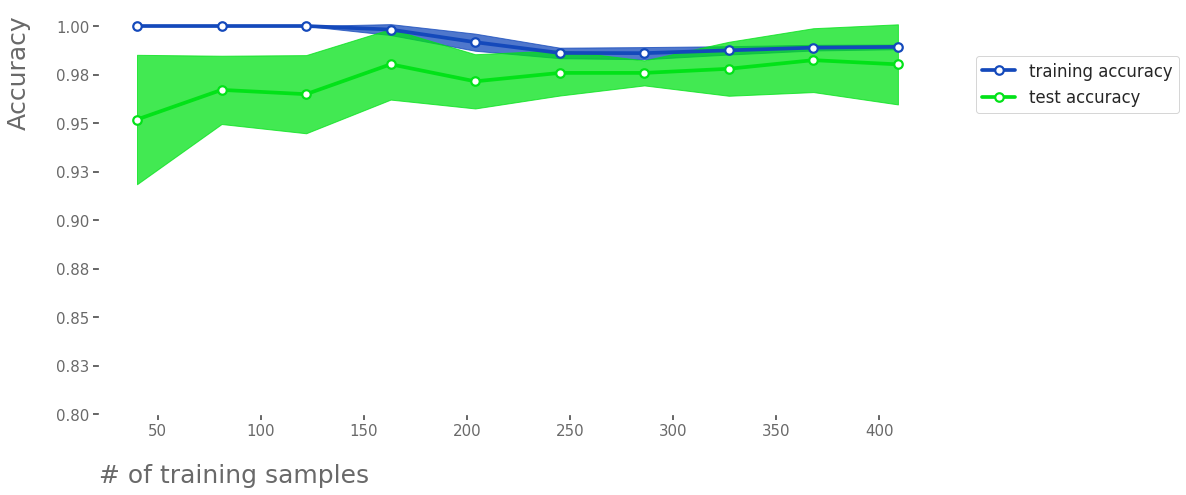

In [9]:
# learning curve
pipe = pipeline.make_pipeline(
    preprocessing.StandardScaler(),
    linear_model.LogisticRegression(penalty="l2", random_state=1),
)
train_sizes, train_scores, test_scores = model_selection.learning_curve(
    estimator=pipe,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=10,
    n_jobs=1,
)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# training accuracy
p = PrettierPlot()
ax = p.make_canvas(x_label="# of training samples", y_label="Accuracy", y_shift=0.7)

p.line(
    x=train_sizes,
    y=train_mean,
    ax=ax,
    marker_on=True,
    label="training accuracy",
    linecolor=style.style_blue,
    y_units="fff",
)
plt.fill_between(
    train_sizes,
    train_mean + train_std,
    train_mean - train_std,
    alpha=0.75,
    color=style.style_blue,
)

# test accuracy
p.line(
    x=train_sizes,
    y=test_mean,
    ax=ax,
    marker_on=True,
    linecolor=style.style_green,
    label="test accuracy",
    y_units="fff",
    bbox=(1.3, 0.9),
)
plt.fill_between(
    train_sizes,
    test_mean + test_std,
    test_mean - test_std,
    alpha=0.75,
    color=style.style_green,
)

plt.ylim([0.8, 1.01])

> Remarks - learning_curve runs for 10 progressively larger datasets, and on each run completed 10-fold stratified CV. The plot shows the test and train mean scores for each sample size, and a band showing the +/- standard deviation for each trend. It is clear that as the training dataset size increases, the variation between the train and test mean accuracy decreases.

# Addressing overfitting and underfitting with validation curves

Validation curves are similar to learning curves, but different in that rather than plotting accuracy vs. sample size, we plot accuracy vs. a range of values for a certain paramater.

<a id = 'Addressing-overfitting-and-underfitting-with-validation-curves'></a>

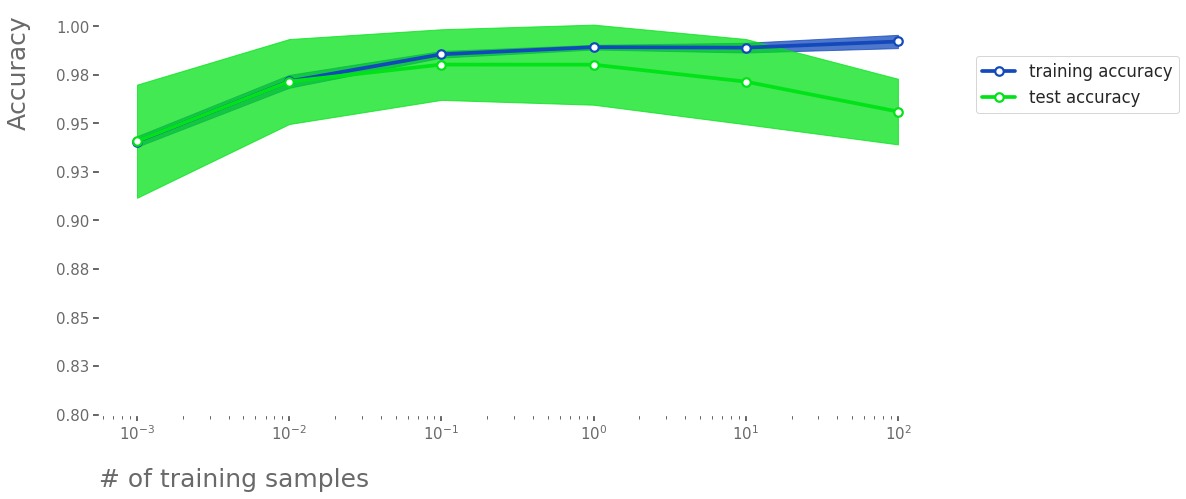

In [10]:
# validation curve
param_range = np.array([0.001, 0.01, 0.1, 1.0, 10.0, 100.0])
train_scores, test_scores = model_selection.validation_curve(
    estimator=pipe,
    X=X_train,
    y=y_train,
    param_name="logisticregression__C",
    param_range=param_range,
    cv=10,
)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# training accuracy
p = PrettierPlot()
ax = p.make_canvas(x_label="# of training samples", y_label="Accuracy", y_shift=0.7)

p.line(
    x=param_range,
    y=train_mean,
    ax=ax,
    marker_on=True,
    label="training accuracy",
    linecolor=style.style_blue,
    y_units="fff",
)
plt.fill_between(
    param_range,
    train_mean + train_std,
    train_mean - train_std,
    alpha=0.75,
    color=style.style_blue,
)

# test accuracy
p.line(
    x=param_range,
    y=test_mean,
    ax=ax,
    marker_on=True,
    linecolor=style.style_green,
    label="test accuracy",
    y_units="fff",
    bbox=(1.3, 0.9),
)
plt.fill_between(
    param_range,
    test_mean + test_std,
    test_mean - test_std,
    alpha=0.75,
    color=style.style_green,
)

plt.xscale("log")
plt.ylim([0.8, 1.01])
plt.grid()

> Remarks - Similar to the learning_curve example, validation_curve executes 10-fold stratified CV for varying values of LogisticRegression's parameter C. The average train and test scores are plotted along with the corresponding standard deviations. Based on this visualization, it appears that the algorithm underfits the data for lower values of C and overfits for larger values of C. The sweet spot is around $10^{-1}$

# Fine-tuning machine learning models via grid search

Grid search is an effective technique for training models on many different combinations of hyperparameters

<a id = 'Fine-tuning-machine-learning-models-via-grid-search'></a>

In [11]:
# perform GridSearchCV for linear SVC with varying values of C, and RBF SVC with varying levels of C and gamma.
# return accuracy score
pipe = pipeline.make_pipeline(preprocessing.StandardScaler(), svm.SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [
    {"svc__C": param_range, "svc__kernel": ["linear"]},
    {"svc__C": param_range, "svc__gamma": param_range, "svc__kernel": ["rbf"]},
]
gs = model_selection.GridSearchCV(
    estimator=pipe, param_grid=param_grid, scoring="accuracy", cv=10, n_jobs=-1
)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846153846153847
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [12]:
# evaluate on test data
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print("Test accuracy: {:.3f}".format(clf.score(X_test, y_test)))

Test accuracy: 0.974


## Algorithm selection with nested cross-validation

When using Nested CV it has been shown that the true error of the estimate is almost unbiased relative to the test set. This technique has an outer k-fold CV to split the data into train and test folds, and an inner loop for selecting the tuning the parameters using k-fold CV on the training fold only. This is helpful when analyzing large datasets when computational performance is important. One particular type of nested CV is called 5x2 CV where the outer loop is a 5-fold CV and the inner loop is 2-fld CV.

<a id = 'Algorithm-selection-with-nested-cross-validation'></a>

In [13]:
# inner loop CV
gs = model_selection.GridSearchCV(
    estimator=pipe, param_grid=param_grid, scoring="accuracy", cv=2
)

# outer loop CV, passing inner loop CV into it as the estimator
scores = model_selection.cross_val_score(gs, X_train, y_train, scoring="accuracy", cv=5)
print("CV accuracy: {:.3f} +/- {:.3f}".format(np.mean(scores), np.std(scores)))

CV accuracy: 0.974 +/- 0.015


> Remarks - The average CV accuracy gives a good estimate of what to expect if we tune the hyperparameters of a model and use it on unseen data.

In [14]:
# another nested CV example with DecisionTreeClassifier
# inner loop CV
gs = model_selection.GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=0),
    param_grid=[{"max_depth": [1, 2, 3, 4, 5, 6, 7, None]}],
    scoring="accuracy",
    cv=2,
)

# outer loop CV, passing inner loop CV into it as the estimator
scores = model_selection.cross_val_score(gs, X_train, y_train, scoring="accuracy", cv=5)
print("CV accuracy: {:.3f} +/- {:.3f}".format(np.mean(scores), np.std(scores)))

CV accuracy: 0.934 +/- 0.016


> Remarks - The SVM model is the better choice of the two.

# Performance evaluation metrics

In addition to accuracy, there are sveral other metrics that are useful for evaluating classification models.

<a id = 'Performance-evaluation-metrics'></a>

## Confusion matrix

A confusion matrix describes how a classifier gets it right and gets it wrong. In a 2x2 confusion matrix, the four cells are:

- True positive (TP): Correct positive
- False positive (TN): Incorrectly identified as positive, also known as Type 1 Error
- True negative (TN): Correct negative
- False negative (TN): Incorrectly identified as negative, also known as Type 2 Error

<a id = 'Confusion-matrix'></a>

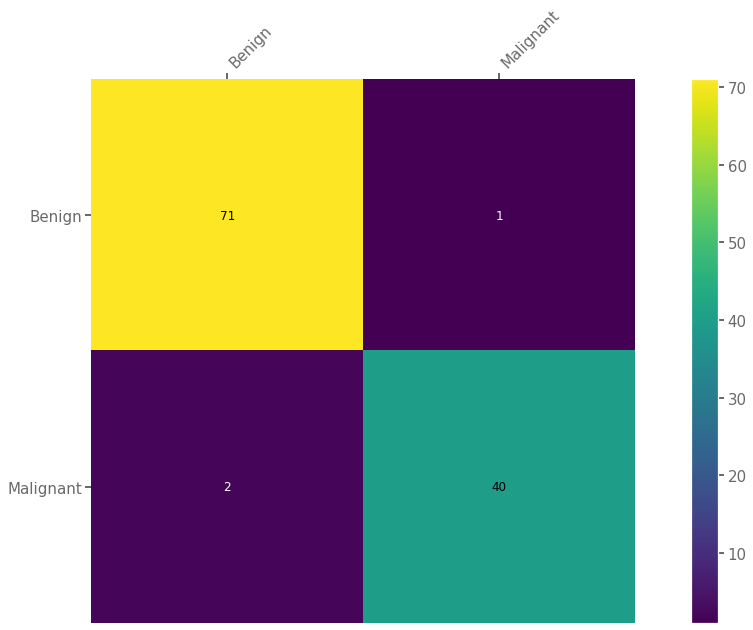

In [15]:
# generate predictions using test set
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# visualize results with confusion matrix
p = PrettierPlot(chart_prop=20)
p.confusion_matrix(y_pred, y_test, labels=["Benign", "Malignant"])
plt.show()

> Remarks - 40 TPs, 71 TNs. 1 tumor was predicted as malignant but was actually benign, and 2 cases were predicted to be benign but were actually malignant.

## Optimizing the precision and recall of a classification model

There are many different ways to understand how the various components of the confusion matrix relate to each other. The two basic metrics are error rate and accuracy. The formula for the error rate: 

$$
ERR = \frac{FP + FN}{FP +FN + TP+ TN}
$$

And the prediction accuracy:

$$
ACC = \frac{TP + TN}{FP +FN + TP+ TN} = 1 - ERR
$$

These are general metrics that are always worth checking, but in the case of imbalanced problems where one class vastly out numbers another class, there are other metrics that are essential for model validation:

True Positive Rate (Recall), False Positive Rate and Precision:

$$
TPR(Recall) = \frac{TP}{P} = \frac{TP}{TP + FN}
$$

$$
FPR = \frac{FP}{N} = \frac{FP}{FP + TN}
$$

$$
PRE = \frac{TP}{TP + FP}
$$

Precision and recall can be combined to create the F1-score
$$
F1 = 2\frac{PRE x REC}{PRE + REC}
$$


<a id = 'Optimizing-the-precision-and-recall-of-a-classification-model'></a>

In [16]:
# evaluate model using precision, recall and F1 score
print("Precision: {:.3f}".format(metrics.precision_score(y_true=y_test, y_pred=y_pred)))
print("Recall: {:.3f}".format(metrics.recall_score(y_true=y_test, y_pred=y_pred)))
print("F1: {:.3f}".format(metrics.f1_score(y_true=y_test, y_pred=y_pred)))

Precision: 0.976
Recall: 0.952
F1: 0.964


## Receiver operating characteristic

Graphs of the receiver operating characteristic (ROC) illustrate how the FPR and TPR relate to each other. The diagonal is interpreted as random guessing, the space below the diagonal represents predictions worse than random guessing, and the space above the diagnonal represents predictive power. A perfect classifier would have a curve that aligns with the upper left hand corner of the plot, indicating a TPR of 1 and a FPR of 0. Plotting the relationship of TPR and FPR often results in a curve, so we can quantify the accuracy of the model by calculating the area under the curve (AUC). 

<a id = 'Receiver-operating-characteristic'></a>

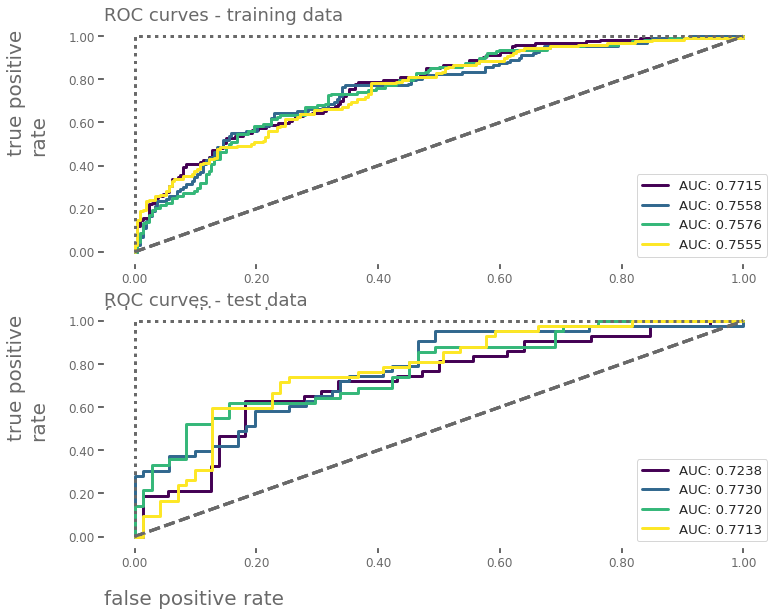

In [17]:
# plot and ROC curve using only two features from the breast cancer dataset
pipe = pipeline.make_pipeline(
    preprocessing.StandardScaler(),
    decomposition.PCA(n_components=2),
    linear_model.LogisticRegression(penalty="l2", random_state=1, C=100.0),
)
X_train2 = X_train[:, [4, 14]]
cv = list(
    model_selection.StratifiedKFold(n_splits=4, random_state=1).split(X_train, y_train)
)

# plot ROC curves
p = PrettierPlot(chart_prop=12, plot_orientation="square")

# training data
ax = p.make_canvas(
    title="ROC curves - training data",
    x_label="false positive rate",
    y_label="true positive \nrate",
    y_shift=0.45,
    position=211,
)

# colors
color_list = style.colorGen(num=len(cv))

for i, (train, test) in enumerate(cv):
    X_train_cv = X_train2[train]
    y_train_cv = y_train[train]

    p.roc_curve(
        model=pipe,
        X_train=X_train_cv,
        y_train=y_train_cv,
        linecolor=color_list[i],
        ax=ax,
    )

# test data
ax = p.make_canvas(
    title="ROC curves - test data",
    x_label="false positive rate",
    y_label="true positive \nrate",
    y_shift=0.45,
    position=212,
)

for i, (train, test) in enumerate(cv):
    X_train_cv = X_train2[train]
    y_train_cv = y_train[train]
    X_test_cv = X_train2[test]
    y_test_cv = y_train[test]

    p.roc_curve(
        model=pipe,
        X_train=X_train_cv,
        y_train=y_train_cv,
        X_valid=X_test_cv,
        y_valid=y_test_cv,
        linecolor=color_list[i],
        ax=ax,
    )

> Remarks - Each CV returns a score better than random guessing.

## Scoring metrics for multiclass classification

The metric above apply to binary classificationm problems. sklearn implememts, macro and micro averaging methods to mextend those scoring metrics to multiclass problems via One-vs-All(OvA). The micro average is calculated from the individual TPs, TNs, FPs, and FNs of the system. The micro average of thenprecisionmscore in a $k$-class system is:

$$
PRE_{micro} = \frac{TP_1 + ... + TP_k}{TP_1 + ... + TP_k + FP_1 + ... + FP_k}
$$

The macro average is calculated as the average scores of the different systems:

$$
PRE_{macro} = \frac{PRE_1 + ... + PRE_k}{k}
$$

Micro averaging is used to weight each instance or prediction equally, whereas macro averaging weights all classes equally to evaluate the overall performance of a classifier with regard to the most frequent class labels.

<a id = 'Scoring-metrics-for-multiclass-classification'></a>

# Dealing with class imbalance

Class imbalances occur when one class or multiple classes are over-represented in the dataset. This occurs often in fraud, spam filtering and disease screening.

The topic of breast cancer detection is an example of an imbalanced dataset. If 90 percent of cases are benign, then a model with an accurayc of 90% is about as good as random guessing. Simply guessing 'benign' would achieve roughly a 90% accuracy.

sklearn allows for penalizing wrong predictions more heavily by specifying class_weight = 'balanced' in the model.

<a id = 'Dealing-with-class-imbalance'></a>

In [18]:
# create an imbalanced dataset by stacking all benign observations
# with only 40 malignant observations
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

# simulate random guessing achieving 90%
y_pred = np.zeros(y_imb.shape[0])
np.round((np.mean(y_pred == y_imb) * 100), 3)

89.924

> Remarks - With an imbalanced dataset like this, it would preferable to use metrics such as precision and recall. The metric we choose depends on how we value the occurrence of FPs vs. FNs.

## Sampling techniques for imbalanced datasets

Upsampling the minority class, downsampling the majority class, and the generation of synthetic minority samples are a few techniques for addressing imbalanced problems.

sklearn implements resample, whichn allows for upsampling the minority class by drawing new samples with replacement.

<a id = 'Sampling-techniques-for-imbalanced-datasets'></a>

In [22]:
# upsampling simulation
print("# of class 1 samples before: {0}".format(X_imb[y_imb == 1].shape[0]))

XUpsampled, yUpsampled = utils.resample(
    X_imb[y_imb == 1],
    y_imb[y_imb == 1],
    replace=True,
    n_samples=X_imb[y_imb == 0].shape[0],
    random_state=1,
)
print("# of class 1 samples after: {0}".format(XUpsampled.shape[0]))

X_bal = np.vstack((X[y == 0], XUpsampled))
y_bal = np.hstack((y[y == 0], yUpsampled))

# simulate random guessing achieving 50% now that dataset is balanced
y_pred = np.zeros(y_bal.shape[0])
np.round((np.mean(y_pred == y_bal) * 100), 3)

# of class 1 samples before: 40
# of class 1 samples after: 357


50.0